## Bear Classifier

In [56]:
# which makes sure any updates to the underlying library at any point of time 
#should be automatically reloaded/refreshed. 

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")



#### Download images from google using this command.

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

In [57]:
# import libraries
from fastai import *
from fastai.vision import *

### Create directory

In [48]:
# function creates directory and downloads files

def create_dir(folder_name, file_name):
    path = Path('Bear Classification/data/bears')
    dest = path/folder_name
    dest.mkdir(parents=True, exist_ok=True)
    print(path.ls())
    download_images(path/file_name, dest, max_pics=200)
    

In [43]:
create_dir('black', 'black bear.txt')

In [44]:
create_dir('grizzly', 'grizzly.txt')

In [45]:
create_dir('teddy', 'teddy.txt')

In [50]:
classes = ['teddy','grizzly','black']

In [47]:
path.ls()

[PosixPath('Bear Classification/data/bears/teddy.txt'),
 PosixPath('Bear Classification/data/bears/black'),
 PosixPath('Bear Classification/data/bears/black bear.txt'),
 PosixPath('Bear Classification/data/bears/teddy'),
 PosixPath('Bear Classification/data/bears/grizzly'),
 PosixPath('Bear Classification/data/bears/grizzly.txt'),
 PosixPath('Bear Classification/data/bears/.ipynb_checkpoints')]

In [51]:
# remove any images that can't be opened:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

In [58]:
# set seed
np.random.seed(101)

### Create Image Data Bunch 

In [59]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [60]:
data

ImageDataBunch;

Train: LabelList (432 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
black,black,black,black,black
Path: Bear Classification/data/bears;

Valid: LabelList (107 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
grizzly,black,grizzly,black,teddy
Path: Bear Classification/data/bears;

Test: None

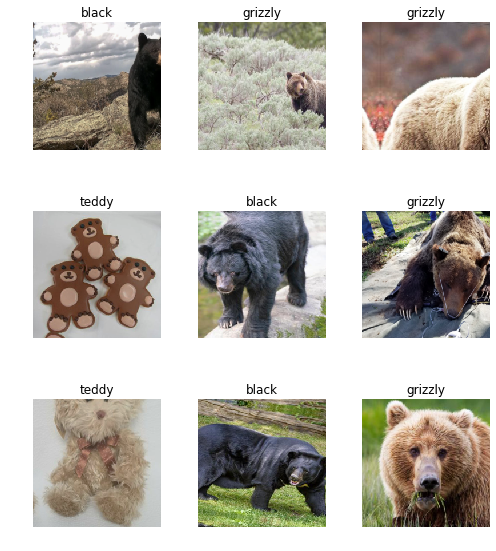

In [61]:
data.show_batch(rows=3, figsize=(7,8))

### Create and Train Model

In [62]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/bharat/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [02:16<00:00, 638kB/s] 


In [63]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.335764,0.030633,0.009346,02:18
1,0.716346,0.037109,0.009346,02:13
2,0.494839,0.036549,0.009346,02:26
3,0.390181,0.032889,0.009346,02:12


The model is really good, the error rate is mind blowing.

In [65]:
# save model
learn.save('stage1')

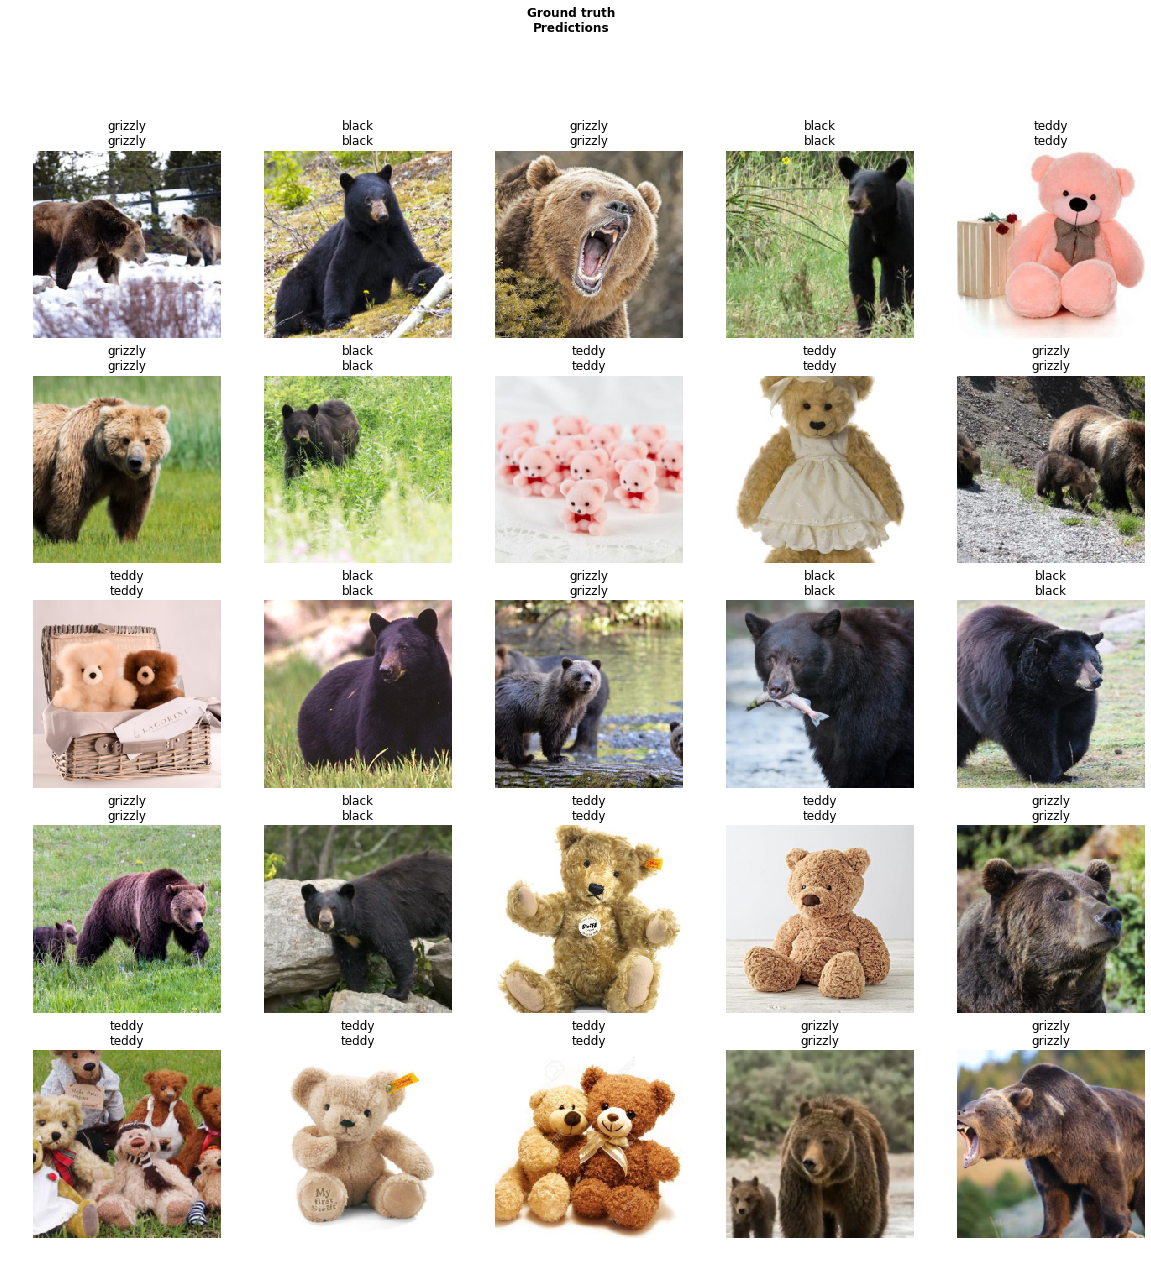

In [66]:
# see results
learn.show_results()

In [67]:
# let's see where the model goes wrong
interp = ClassificationInterpretation.from_learner(learn)

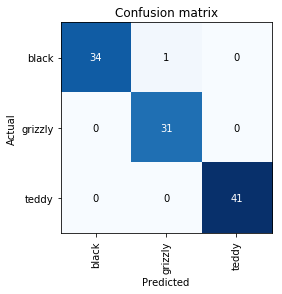

In [70]:
interp.plot_confusion_matrix()

There's only one image that our model has predicted wrong

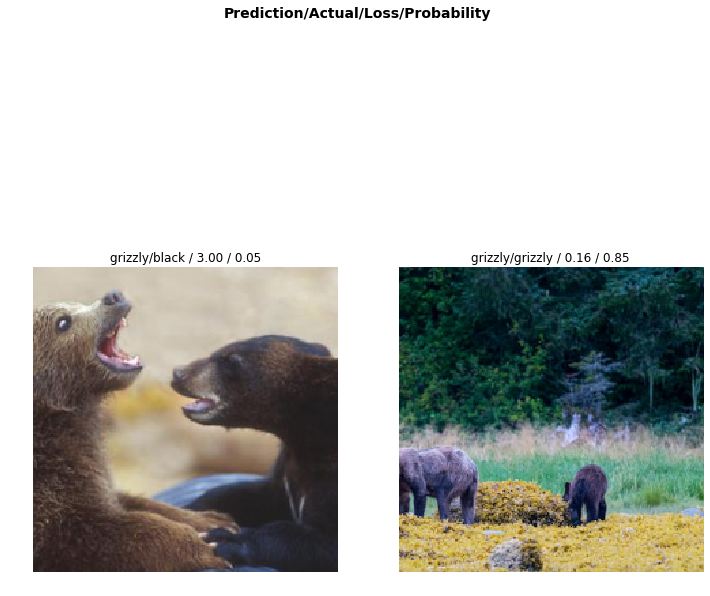

In [79]:
# let's take a look at that image
interp.plot_top_losses(2)

Even I'm confused wheather it's a grizzly or a black bear

### Cleaning

In [80]:
from fastai.widgets import *

losses,idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

In [86]:
# calculate the losses
losses, idxs = DatasetFormatter().from_toplosses(learn)

It will display a widget, in which images, as well as their classes, will be displayed. You can select the images you want to remove from the dataset. The idea is to delete the images which are not unrelated to any of the classes. Click on Next Batch to see a new set of images, select the one you want to remove.
Notice that the widget will not delete images directly from disk but it will create a new CSV file cleaned.csv from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In [88]:
# run the image cleaner
ImageCleaner(losses, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [89]:
# Create new databunch using the ‘cleaned.csv’ and train a model using it.
# data_cleaned = ImageDataBunch.from_csv(path, csv_labels='cleaned.csv',
#                                        label_col=1,
#                                        valid_pct=0.2,
#                                        ds_tfms=get_transforms(), size=224, 
#                                        num_workers=0).normalize(imagenet_stats)

In [90]:
# export model
learn.export()

/home/bharat/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/bharat/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/bharat/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/bharat/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj._

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [91]:
defaults.device = torch.device('cpu')

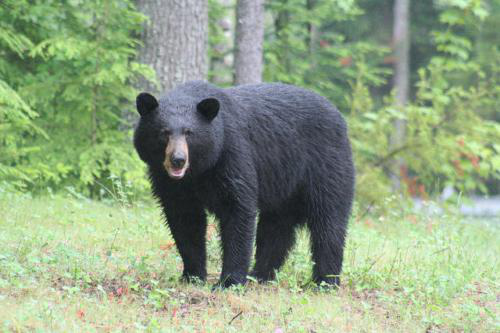

In [92]:
img = open_image(path/'black'/'00000021.jpg')
img

In [93]:
learn = load_learner(path)

In [94]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category black